In [6]:
#!/usr/bin/env python
# enhanced_multi_model_churn_analysis.py

import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score,
    precision_score, recall_score, f1_score, accuracy_score
)
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.calibration import calibration_curve
import lightgbm as lgb
import xgboost as xgb
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import warnings
warnings.filterwarnings('ignore')


# allow imports from project root
sys.path.append(str(Path().resolve().parent))
from customer_ai.config import PROCESSED_DATA_DIR


# ───────────────────────────────────────────────────────────────────────────────
# CONFIG
# ───────────────────────────────────────────────────────────────────────────────
SEED = 42
MODEL_DIR = PROCESSED_DATA_DIR / "models" / "churn"
MODEL_DIR.mkdir(exist_ok=True)

2025-07-04 17:14:04.742 | INFO     | customer_ai.config:<module>:11 - PROJ_ROOT path is: /home/gwei4/e_commerce_customer_ai_platform


🚀 Starting Enhanced Multi-Model Churn Analysis
Dataset shapes:
Train: (79552, 35)
Val:   (9944, 35)
Test:  (9945, 35)
Found 32 features

Class distribution:
Train - Churned: 56368/79552 (70.9%)
Val   - Churned: 7046/9944 (70.9%)
Test  - Churned: 7047/9945 (70.9%)
⚠️ Found 2 constant features: ['delivery_actual_days_std', 'delivery_inconsistent']
✅ Final feature count: 30

🔧 Training Models...
----------------------------------------
Training Logistic Regression...
Training LightGBM...
Training XGBoost...

MODEL COMPARISON


[I 2025-07-04 17:24:11,629] A new study created in memory with name: no-name-80fea502-e212-4d40-a212-5faebc3f02ef


                     Train AUC  Val AUC  Test AUC  Train F1  Val F1  Test F1  \
Logistic Regression     0.8481   0.8456    0.8293    0.7452  0.7445   0.7228   
LightGBM                0.9053   0.8818    0.8660    0.8073  0.7920   0.7695   
XGBoost                 0.9037   0.8815    0.8652    0.8057  0.7912   0.7668   

                     Val Precision  Val Recall  
Logistic Regression         0.9816      0.5996  
LightGBM                    0.9546      0.6767  
XGBoost                     0.9541      0.6758  

🏆 Best Model: LightGBM
   Validation AUC: 0.8818
   Test AUC: 0.8660

🔍 Optimizing LightGBM with Optuna (50 trials)...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-07-04 17:24:20,726] Trial 0 finished with value: 0.8785428267728411 and parameters: {'n_estimators': 529, 'learning_rate': 0.14767832174484055, 'num_leaves': 250, 'max_depth': 10, 'min_child_samples': 47, 'subsample': 0.8102428136149968, 'colsample_bytree': 0.87733378445255, 'reg_alpha': 4.802945718982201, 'reg_lambda': 5.061857613637082}. Best is trial 0 with value: 0.8785428267728411.
[I 2025-07-04 17:24:25,040] Trial 1 finished with value: 0.8799142378625997 and parameters: {'n_estimators': 971, 'learning_rate': 0.18294468337243586, 'num_leaves': 20, 'max_depth': 10, 'min_child_samples': 81, 'subsample': 0.7156905025872768, 'colsample_bytree': 0.9732014766212997, 'reg_alpha': 6.0529446106875096, 'reg_lambda': 8.266712351549238}. Best is trial 1 with value: 0.8799142378625997.
[I 2025-07-04 17:24:30,186] Trial 2 finished with value: 0.8796321969440055 and parameters: {'n_estimators': 366, 'learning_rate': 0.05338846170601504, 'num_leaves': 182, 'max_depth': 8, 'min_child_samp

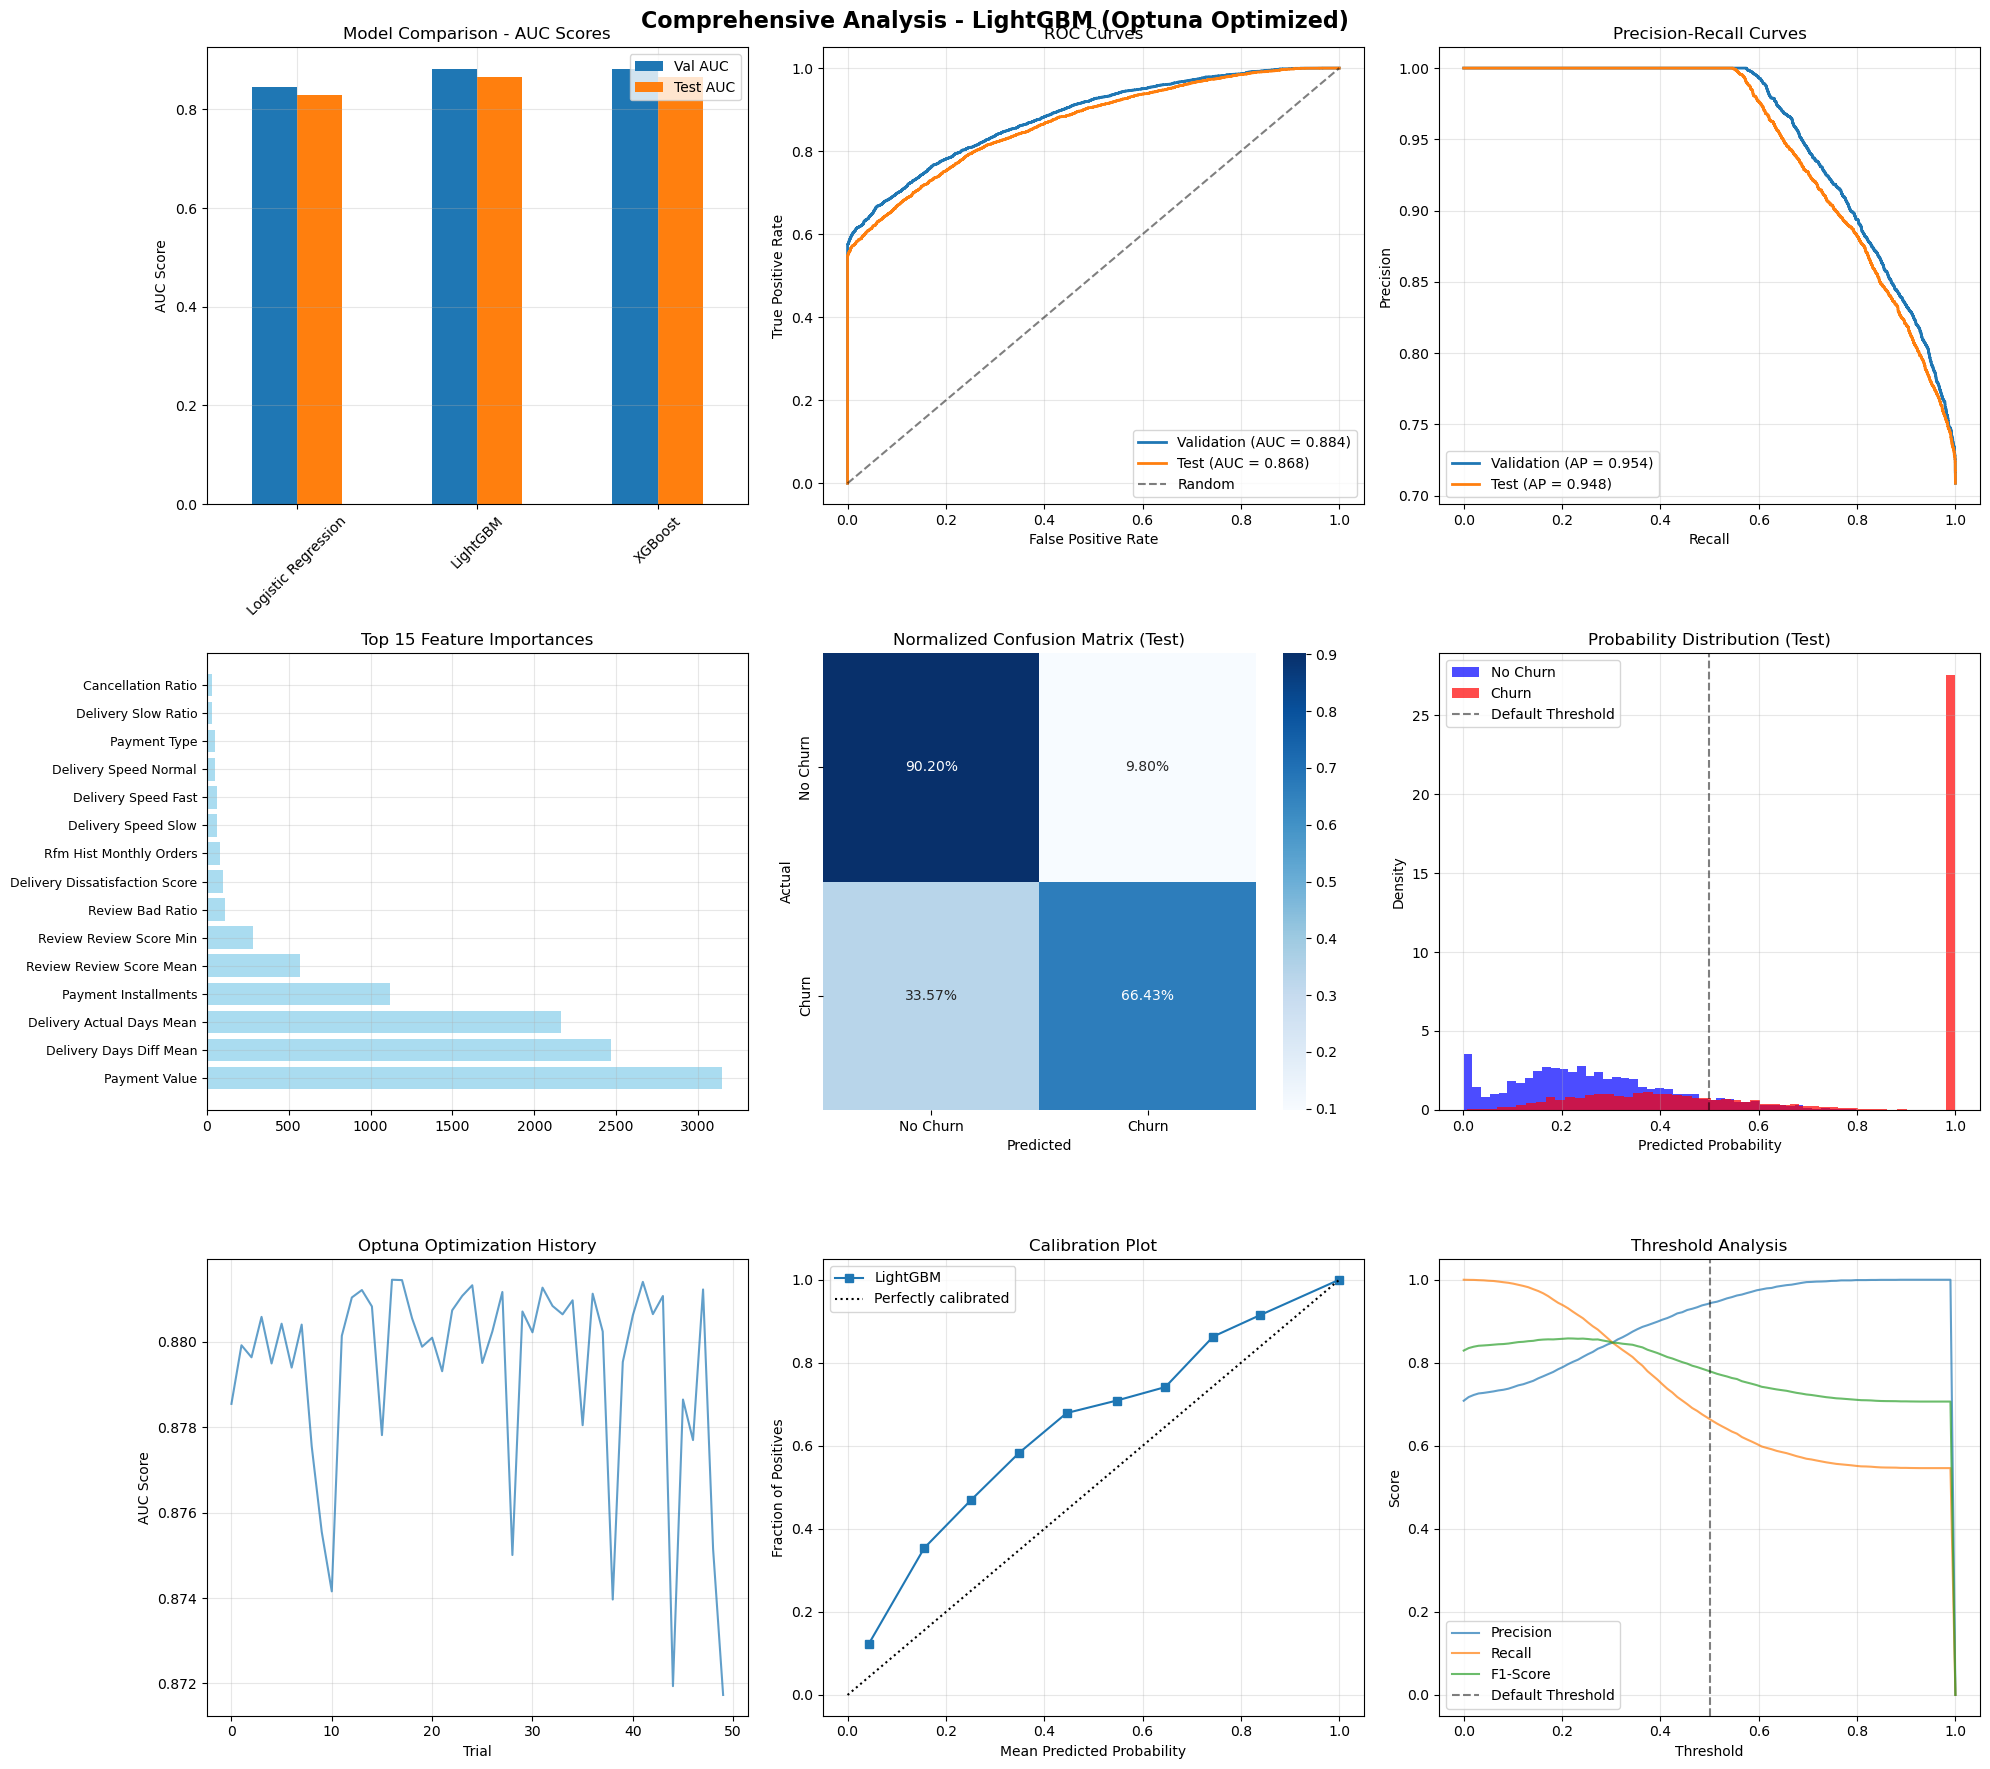


🔍 BUSINESS INSIGHTS & RECOMMENDATIONS
📊 MODEL PERFORMANCE SUMMARY - LightGBM
--------------------------------------------------
• Test AUC: 0.868 (Excellent)
• Precision: 0.943 (Out of customers predicted to churn, 94.3% actually churn)
• Recall: 0.664 (Model identifies 66.4% of all churning customers)
• F1-Score: 0.779 (Balanced measure of precision and recall)

🎯 KEY CHURN DRIVERS
--------------------------------------------------
1. Payment Value: High predictive power (importance: 3146.000)
2. Delivery Days Diff Mean: High predictive power (importance: 2469.000)
3. Delivery Actual Days Mean: High predictive power (importance: 2165.000)
4. Payment Installments: High predictive power (importance: 1116.000)
5. Review Review Score Mean: High predictive power (importance: 566.000)

📈 CUSTOMER RISK SEGMENTATION
--------------------------------------------------
• High Risk (≥70%): 4,028 customers (40.5%) - Actual churn rate: 99.5%
• Medium Risk (30-70%): 3,045 customers (30.6%) - Actual

In [8]:
# ───────────────────────────────────────────────────────────────────────────────
# 1. LOAD DATA
# ───────────────────────────────────────────────────────────────────────────────
def load_datasets():
    """Load the train/val/test datasets created by features_churn.py"""
    train_df = pd.read_parquet(PROCESSED_DATA_DIR / f"churn_train_seed{SEED}.parquet")
    val_df = pd.read_parquet(PROCESSED_DATA_DIR / f"churn_val_seed{SEED}.parquet")
    test_df = pd.read_parquet(PROCESSED_DATA_DIR / f"churn_test_seed{SEED}.parquet")
    
    print("Dataset shapes:")
    print(f"Train: {train_df.shape}")
    print(f"Val:   {val_df.shape}")
    print(f"Test:  {test_df.shape}")
    
    return train_df, val_df, test_df

# ───────────────────────────────────────────────────────────────────────────────
# 2. PREPARE FEATURES
# ───────────────────────────────────────────────────────────────────────────────
def prepare_features(train_df, val_df, test_df):
    """Separate features and target, handle scaling"""
    
    # Identify feature columns (everything except id and target)
    feature_cols = [col for col in train_df.columns 
                   if col not in ['customer_id', 'is_churned', 'days_since_last_order']]
    
    print(f"Found {len(feature_cols)} features")
    
    # Separate features and target
    X_train = train_df[feature_cols]
    y_train = train_df['is_churned']
    
    X_val = val_df[feature_cols]
    y_val = val_df['is_churned']
    
    X_test = test_df[feature_cols]
    y_test = test_df['is_churned']
    
    # Print class distribution
    print("\nClass distribution:")
    print(f"Train - Churned: {y_train.sum()}/{len(y_train)} ({y_train.mean():.1%})")
    print(f"Val   - Churned: {y_val.sum()}/{len(y_val)} ({y_val.mean():.1%})")
    print(f"Test  - Churned: {y_test.sum()}/{len(y_test)} ({y_test.mean():.1%})")
    
    # Remove constant features
    constant_features = X_train.columns[X_train.nunique() <= 1]
    if len(constant_features) > 0:
        print(f"⚠️ Found {len(constant_features)} constant features: {list(constant_features)}")
        X_train = X_train.drop(columns=constant_features)
        X_val = X_val.drop(columns=constant_features)
        X_test = X_test.drop(columns=constant_features)
        feature_cols = [col for col in feature_cols if col not in constant_features]
    
    # Scale features for logistic regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert back to DataFrames
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_cols, index=X_val.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)
    
    print(f"✅ Final feature count: {len(feature_cols)}")
    
    return (X_train, y_train, X_val, y_val, X_test, y_test, 
            X_train_scaled, X_val_scaled, X_test_scaled, feature_cols, scaler)

# ───────────────────────────────────────────────────────────────────────────────
# 3. MODEL TRAINING FUNCTIONS
# ───────────────────────────────────────────────────────────────────────────────

def train_logistic_regression(X_train, y_train, X_val, y_val):
    """Train logistic regression with basic hyperparameter tuning"""
    
    C_values = [0.01, 0.1, 1.0, 10.0, 100.0]
    best_score = 0
    best_model = None
    best_params = {}
    
    print("Training Logistic Regression...")
    
    for C in C_values:
        model = LogisticRegression(
            C=C,
            random_state=SEED,
            max_iter=1000,
            class_weight='balanced'
        )
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
        cv_mean = cv_scores.mean()
        
        if cv_mean > best_score:
            best_score = cv_mean
            best_model = model
            best_params = {'C': C}
    
    best_model.fit(X_train, y_train)
    val_auc = roc_auc_score(y_val, best_model.predict_proba(X_val)[:, 1])
    
    return best_model, best_params, val_auc

def train_lightgbm(X_train, y_train, X_val, y_val):
    """Train LightGBM with basic hyperparameter tuning"""
    
    print("Training LightGBM...")
    
    # Basic parameter grid
    params_grid = [
        {'n_estimators': 100, 'learning_rate': 0.1, 'num_leaves': 31, 'max_depth': -1},
        {'n_estimators': 200, 'learning_rate': 0.05, 'num_leaves': 31, 'max_depth': -1},
        {'n_estimators': 300, 'learning_rate': 0.03, 'num_leaves': 63, 'max_depth': -1},
        {'n_estimators': 500, 'learning_rate': 0.01, 'num_leaves': 127, 'max_depth': -1},
    ]
    
    best_score = 0
    best_model = None
    best_params = {}
    
    for params in params_grid:
        model = lgb.LGBMClassifier(
            **params,
            random_state=SEED,
            class_weight='balanced',
            verbosity=-1
        )
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
        cv_mean = cv_scores.mean()
        
        if cv_mean > best_score:
            best_score = cv_mean
            best_model = model
            best_params = params
    
    best_model.fit(X_train, y_train)
    val_auc = roc_auc_score(y_val, best_model.predict_proba(X_val)[:, 1])
    
    return best_model, best_params, val_auc

def train_xgboost(X_train, y_train, X_val, y_val):
    """Train XGBoost with basic hyperparameter tuning"""
    
    print("Training XGBoost...")
    
    # Calculate scale_pos_weight for imbalanced data
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    
    # Basic parameter grid
    params_grid = [
        {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 6, 'subsample': 0.8},
        {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 6, 'subsample': 0.8},
        {'n_estimators': 300, 'learning_rate': 0.03, 'max_depth': 8, 'subsample': 0.7},
        {'n_estimators': 500, 'learning_rate': 0.01, 'max_depth': 10, 'subsample': 0.7},
    ]
    
    best_score = 0
    best_model = None
    best_params = {}
    
    for params in params_grid:
        model = xgb.XGBClassifier(
            **params,
            random_state=SEED,
            scale_pos_weight=scale_pos_weight,
            verbosity=0
        )
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
        cv_mean = cv_scores.mean()
        
        if cv_mean > best_score:
            best_score = cv_mean
            best_model = model
            best_params = params
    
    best_model.fit(X_train, y_train)
    val_auc = roc_auc_score(y_val, best_model.predict_proba(X_val)[:, 1])
    
    return best_model, best_params, val_auc

# ───────────────────────────────────────────────────────────────────────────────
# 4. MODEL COMPARISON
# ───────────────────────────────────────────────────────────────────────────────

def compare_models(models_dict, X_train, y_train, X_val, y_val, X_test, y_test, 
                   X_train_scaled, X_val_scaled, X_test_scaled):
    """Compare all models and select the best one"""
    
    print("\n" + "="*60)
    print("MODEL COMPARISON")
    print("="*60)
    
    results = {}
    
    # Evaluate each model
    for name, model_info in models_dict.items():
        model = model_info['model']
        
        # Use scaled data for logistic regression, original for tree models
        if name == 'Logistic Regression':
            X_tr, X_v, X_te = X_train_scaled, X_val_scaled, X_test_scaled
        else:
            X_tr, X_v, X_te = X_train, X_val, X_test
        
        # Predictions
        train_pred = model.predict(X_tr)
        val_pred = model.predict(X_v)
        test_pred = model.predict(X_te)
        
        train_proba = model.predict_proba(X_tr)[:, 1]
        val_proba = model.predict_proba(X_v)[:, 1]
        test_proba = model.predict_proba(X_te)[:, 1]
        
        # Calculate metrics
        results[name] = {
            'train_auc': roc_auc_score(y_train, train_proba),
            'val_auc': roc_auc_score(y_val, val_proba),
            'test_auc': roc_auc_score(y_test, test_proba),
            'train_f1': f1_score(y_train, train_pred),
            'val_f1': f1_score(y_val, val_pred),
            'test_f1': f1_score(y_test, test_pred),
            'train_precision': precision_score(y_train, train_pred),
            'val_precision': precision_score(y_val, val_pred),
            'test_precision': precision_score(y_test, test_pred),
            'train_recall': recall_score(y_train, train_pred),
            'val_recall': recall_score(y_val, val_pred),
            'test_recall': recall_score(y_test, test_pred),
            'model': model,
            'params': model_info['params']
        }
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame({
        name: {
            'Train AUC': results[name]['train_auc'],
            'Val AUC': results[name]['val_auc'],
            'Test AUC': results[name]['test_auc'],
            'Train F1': results[name]['train_f1'],
            'Val F1': results[name]['val_f1'],
            'Test F1': results[name]['test_f1'],
            'Val Precision': results[name]['val_precision'],
            'Val Recall': results[name]['val_recall']
        }
        for name in results.keys()
    }).T
    
    print(comparison_df.round(4))
    
    # Select best model based on validation AUC
    best_model_name = comparison_df['Val AUC'].idxmax()
    best_model_info = results[best_model_name]
    
    print(f"\n🏆 Best Model: {best_model_name}")
    print(f"   Validation AUC: {best_model_info['val_auc']:.4f}")
    print(f"   Test AUC: {best_model_info['test_auc']:.4f}")
    
    return best_model_name, best_model_info, results, comparison_df

# ───────────────────────────────────────────────────────────────────────────────
# 5. OPTUNA OPTIMIZATION
# ───────────────────────────────────────────────────────────────────────────────

def optimize_with_optuna(best_model_name, X_train, y_train, X_val, y_val, 
                        X_train_scaled, X_val_scaled, n_trials=100):
    """Optimize the best model using Optuna"""
    
    print(f"\n🔍 Optimizing {best_model_name} with Optuna ({n_trials} trials)...")
    
    def objective(trial):
        if best_model_name == 'Logistic Regression':
            C = trial.suggest_float('C', 0.001, 100.0, log=True)
            solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs'])
            
            model = LogisticRegression(
                C=C,
                solver=solver,
                random_state=SEED,
                max_iter=2000,
                class_weight='balanced'
            )
            
            # Use scaled data
            X_tr, X_v = X_train_scaled, X_val_scaled
            
        elif best_model_name == 'LightGBM':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'num_leaves': trial.suggest_int('num_leaves', 20, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 12),
                'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
            }
            
            model = lgb.LGBMClassifier(
                **params,
                random_state=SEED,
                class_weight='balanced',
                verbosity=-1
            )
            
            # Use original data
            X_tr, X_v = X_train, X_val
            
        elif best_model_name == 'XGBoost':
            scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
            
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'max_depth': trial.suggest_int('max_depth', 3, 12),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
            }
            
            model = xgb.XGBClassifier(
                **params,
                random_state=SEED,
                scale_pos_weight=scale_pos_weight,
                verbosity=0
            )
            
            # Use original data
            X_tr, X_v = X_train, X_val
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_tr, y_train, cv=3, scoring='roc_auc')
        return cv_scores.mean()
    
    # Run optimization
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    # Get best parameters and train final model
    best_params = study.best_params
    print(f"Best parameters: {best_params}")
    print(f"Best CV AUC: {study.best_value:.4f}")
    
    # Train final optimized model
    if best_model_name == 'Logistic Regression':
        final_model = LogisticRegression(
            **best_params,
            random_state=SEED,
            max_iter=2000,
            class_weight='balanced'
        )
        final_model.fit(X_train_scaled, y_train)
        
    elif best_model_name == 'LightGBM':
        final_model = lgb.LGBMClassifier(
            **best_params,
            random_state=SEED,
            class_weight='balanced',
            verbosity=-1
        )
        final_model.fit(X_train, y_train)
        
    elif best_model_name == 'XGBoost':
        scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
        final_model = xgb.XGBClassifier(
            **best_params,
            random_state=SEED,
            scale_pos_weight=scale_pos_weight,
            verbosity=0
        )
        final_model.fit(X_train, y_train)
    
    return final_model, best_params, study

# ───────────────────────────────────────────────────────────────────────────────
# 6. COMPREHENSIVE EVALUATION
# ───────────────────────────────────────────────────────────────────────────────

def comprehensive_evaluation(model, model_name, X_train, y_train, X_val, y_val, 
                           X_test, y_test, X_train_scaled, X_val_scaled, X_test_scaled):
    """Comprehensive evaluation of the final model"""
    
    print(f"\n📊 Comprehensive Evaluation - {model_name}")
    print("="*60)
    
    # Use appropriate data
    if model_name == 'Logistic Regression':
        X_tr, X_v, X_te = X_train_scaled, X_val_scaled, X_test_scaled
    else:
        X_tr, X_v, X_te = X_train, X_val, X_test
    
    # Predictions
    sets = {
        'train': (X_tr, y_train),
        'val': (X_v, y_val),
        'test': (X_te, y_test)
    }
    
    predictions = {}
    metrics_data = []
    
    for set_name, (X, y) in sets.items():
        pred = model.predict(X)
        proba = model.predict_proba(X)[:, 1]
        
        predictions[set_name] = {
            'y_true': y,
            'y_pred': pred,
            'y_proba': proba
        }
        
        metrics_data.append({
            'Set': set_name.capitalize(),
            'AUC': roc_auc_score(y, proba),
            'Precision': precision_score(y, pred),
            'Recall': recall_score(y, pred),
            'F1': f1_score(y, pred),
            'Accuracy': accuracy_score(y, pred),
            'Avg Precision': average_precision_score(y, proba)
        })
    
    metrics_df = pd.DataFrame(metrics_data)
    print(metrics_df.round(4).to_string(index=False))
    
    # Feature importance
    if hasattr(model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
    elif hasattr(model, 'coef_'):
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'coefficient': model.coef_[0],
            'importance': np.abs(model.coef_[0])
        }).sort_values('importance', ascending=False)
    else:
        feature_importance = None
    
    return metrics_df, feature_importance, predictions

# ───────────────────────────────────────────────────────────────────────────────
# 7. VISUALIZATION
# ───────────────────────────────────────────────────────────────────────────────

def create_comprehensive_visualizations(model, model_name, comparison_df, 
                                       feature_importance, predictions, study=None):
    """Create comprehensive visualizations"""
    
    print("📊 Creating comprehensive visualizations...")
    
    # Set up the figure
    if study:
        fig, axes = plt.subplots(3, 3, figsize=(20, 18))
        fig.suptitle(f'Comprehensive Analysis - {model_name} (Optuna Optimized)', fontsize=16, fontweight='bold')
    else:
        fig, axes = plt.subplots(3, 2, figsize=(16, 18))
        fig.suptitle(f'Comprehensive Analysis - {model_name}', fontsize=16, fontweight='bold')
    
    axes = axes.flatten()
    
    # 1. Model Comparison
    ax = axes[0]
    comparison_df[['Val AUC', 'Test AUC']].plot(kind='bar', ax=ax, rot=45)
    ax.set_title('Model Comparison - AUC Scores')
    ax.set_ylabel('AUC Score')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. ROC Curves
    ax = axes[1]
    
    val_fpr, val_tpr, _ = roc_curve(predictions['val']['y_true'], predictions['val']['y_proba'])
    test_fpr, test_tpr, _ = roc_curve(predictions['test']['y_true'], predictions['test']['y_proba'])
    
    val_auc = roc_auc_score(predictions['val']['y_true'], predictions['val']['y_proba'])
    test_auc = roc_auc_score(predictions['test']['y_true'], predictions['test']['y_proba'])
    
    ax.plot(val_fpr, val_tpr, label=f'Validation (AUC = {val_auc:.3f})', linewidth=2)
    ax.plot(test_fpr, test_tpr, label=f'Test (AUC = {test_auc:.3f})', linewidth=2)
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curves')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Precision-Recall Curves
    ax = axes[2]
    
    val_precision, val_recall, _ = precision_recall_curve(predictions['val']['y_true'], predictions['val']['y_proba'])
    test_precision, test_recall, _ = precision_recall_curve(predictions['test']['y_true'], predictions['test']['y_proba'])
    
    val_ap = average_precision_score(predictions['val']['y_true'], predictions['val']['y_proba'])
    test_ap = average_precision_score(predictions['test']['y_true'], predictions['test']['y_proba'])
    
    ax.plot(val_recall, val_precision, label=f'Validation (AP = {val_ap:.3f})', linewidth=2)
    ax.plot(test_recall, test_precision, label=f'Test (AP = {test_ap:.3f})', linewidth=2)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curves')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Feature Importance
    if feature_importance is not None:
        ax = axes[3]
        top_features = feature_importance.head(15)
        
        if 'coefficient' in feature_importance.columns:
            colors = ['red' if coef < 0 else 'blue' for coef in top_features['coefficient']]
            values = top_features['coefficient']
            title = 'Top 15 Feature Coefficients'
        else:
            colors = 'skyblue'
            values = top_features['importance']
            title = 'Top 15 Feature Importances'
        
        bars = ax.barh(range(len(top_features)), values, color=colors, alpha=0.7)
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels([f.replace('_', ' ').title() for f in top_features['feature']], fontsize=9)
        ax.set_title(title)
        ax.grid(True, alpha=0.3)
    
    # 5. Confusion Matrix
    ax = axes[4]
    test_pred = predictions['test']['y_pred']
    test_true = predictions['test']['y_true']
    
    cm = confusion_matrix(test_true, test_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=ax,
                xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Normalized Confusion Matrix (Test)')
    
    # 6. Probability Distribution
    ax = axes[5]
    test_proba = predictions['test']['y_proba']
    test_true = predictions['test']['y_true']
    
    churn_proba = test_proba[test_true == 1]
    no_churn_proba = test_proba[test_true == 0]
    
    ax.hist(no_churn_proba, bins=50, alpha=0.7, label='No Churn', density=True, color='blue')
    ax.hist(churn_proba, bins=50, alpha=0.7, label='Churn', density=True, color='red')
    ax.axvline(x=0.5, color='black', linestyle='--', alpha=0.5, label='Default Threshold')
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Density')
    ax.set_title('Probability Distribution (Test)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 7. Optuna optimization history (if available)
    if study and len(axes) > 6:
        ax = axes[6]
        trials = study.trials
        values = [trial.value for trial in trials]
        ax.plot(values, alpha=0.7)
        ax.set_xlabel('Trial')
        ax.set_ylabel('AUC Score')
        ax.set_title('Optuna Optimization History')
        ax.grid(True, alpha=0.3)
    
    # 8. Calibration plot
    if len(axes) > 7:
        ax = axes[7]
        test_proba = predictions['test']['y_proba']
        test_true = predictions['test']['y_true']
        
        fraction_of_positives, mean_predicted_value = calibration_curve(test_true, test_proba, n_bins=10)
        
        ax.plot(mean_predicted_value, fraction_of_positives, "s-", label=model_name)
        ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
        ax.set_xlabel('Mean Predicted Probability')
        ax.set_ylabel('Fraction of Positives')
        ax.set_title('Calibration Plot')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # 9. Threshold analysis
    if len(axes) > 8:
        ax = axes[8]
        test_proba = predictions['test']['y_proba']
        test_true = predictions['test']['y_true']
        
        thresholds = np.linspace(0, 1, 100)
        precision_scores = []
        recall_scores = []
        f1_scores = []
        
        for threshold in thresholds:
            y_pred_thresh = (test_proba >= threshold).astype(int)
            if y_pred_thresh.sum() > 0:  # Avoid division by zero
                precision_scores.append(precision_score(test_true, y_pred_thresh))
                recall_scores.append(recall_score(test_true, y_pred_thresh))
                f1_scores.append(f1_score(test_true, y_pred_thresh))
            else:
                precision_scores.append(0)
                recall_scores.append(0)
                f1_scores.append(0)
        
        ax.plot(thresholds, precision_scores, label='Precision', alpha=0.7)
        ax.plot(thresholds, recall_scores, label='Recall', alpha=0.7)
        ax.plot(thresholds, f1_scores, label='F1-Score', alpha=0.7)
        ax.axvline(x=0.5, color='black', linestyle='--', alpha=0.5, label='Default Threshold')
        ax.set_xlabel('Threshold')
        ax.set_ylabel('Score')
        ax.set_title('Threshold Analysis')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(MODEL_DIR / f'{model_name.lower().replace(" ", "_")}_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

# ───────────────────────────────────────────────────────────────────────────────
# 8. BUSINESS INSIGHTS & RECOMMENDATIONS
# ───────────────────────────────────────────────────────────────────────────────

def generate_business_insights(model, model_name, feature_importance, predictions, metrics_df):
    """Generate comprehensive business insights and recommendations"""
    
    print("\n" + "="*80)
    print("🔍 BUSINESS INSIGHTS & RECOMMENDATIONS")
    print("="*80)
    
    # Model Performance Summary
    test_auc = metrics_df[metrics_df['Set'] == 'Test']['AUC'].values[0]
    test_precision = metrics_df[metrics_df['Set'] == 'Test']['Precision'].values[0]
    test_recall = metrics_df[metrics_df['Set'] == 'Test']['Recall'].values[0]
    test_f1 = metrics_df[metrics_df['Set'] == 'Test']['F1'].values[0]
    
    print(f"📊 MODEL PERFORMANCE SUMMARY - {model_name}")
    print("-" * 50)
    print(f"• Test AUC: {test_auc:.3f} ({'Excellent' if test_auc > 0.85 else 'Good' if test_auc > 0.75 else 'Fair'})")
    print(f"• Precision: {test_precision:.3f} (Out of customers predicted to churn, {test_precision:.1%} actually churn)")
    print(f"• Recall: {test_recall:.3f} (Model identifies {test_recall:.1%} of all churning customers)")
    print(f"• F1-Score: {test_f1:.3f} (Balanced measure of precision and recall)")
    
    # Feature Importance Insights
    if feature_importance is not None:
        print(f"\n🎯 KEY CHURN DRIVERS")
        print("-" * 50)
        
        top_5_features = feature_importance.head(5)
        
        for i, (_, row) in enumerate(top_5_features.iterrows(), 1):
            feature_name = row['feature'].replace('_', ' ').title()
            
            if 'coefficient' in feature_importance.columns:
                coef = row['coefficient']
                impact = "increases" if coef > 0 else "decreases"
                print(f"{i}. {feature_name}: {impact} churn risk (coefficient: {coef:.3f})")
            else:
                importance = row['importance']
                print(f"{i}. {feature_name}: High predictive power (importance: {importance:.3f})")
    
    # Risk Segmentation Analysis
    test_proba = predictions['test']['y_proba']
    test_true = predictions['test']['y_true']
    
    # Define risk segments
    high_risk = test_proba >= 0.7
    medium_risk = (test_proba >= 0.3) & (test_proba < 0.7)
    low_risk = test_proba < 0.3
    
    print(f"\n📈 CUSTOMER RISK SEGMENTATION")
    print("-" * 50)
    
    segments = [
        ("High Risk (≥70%)", high_risk),
        ("Medium Risk (30-70%)", medium_risk),
        ("Low Risk (<30%)", low_risk)
    ]
    
    for segment_name, segment_mask in segments:
        segment_size = segment_mask.sum()
        segment_pct = segment_size / len(test_proba) * 100
        
        if segment_size > 0:
            actual_churn_rate = test_true[segment_mask].mean()
            print(f"• {segment_name}: {segment_size:,} customers ({segment_pct:.1f}%) - "
                  f"Actual churn rate: {actual_churn_rate:.1%}")
    
    # Business Impact Analysis
    print(f"\n💰 BUSINESS IMPACT ANALYSIS")
    print("-" * 50)
    
    # Confusion matrix for business metrics
    test_pred = predictions['test']['y_pred']
    cm = confusion_matrix(test_true, test_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"• True Positives (Correctly identified churners): {tp:,}")
    print(f"• False Positives (Incorrectly flagged as churners): {fp:,}")
    print(f"• False Negatives (Missed churners): {fn:,}")
    print(f"• True Negatives (Correctly identified loyal customers): {tn:,}")
    
    # Assume business values (these should be provided by business stakeholders)
    avg_customer_value = 500  # Average customer lifetime value
    retention_cost = 50      # Cost of retention campaign per customer
    retention_success_rate = 0.3  # Success rate of retention campaigns
    
    # Calculate business impact
    revenue_saved = tp * avg_customer_value * retention_success_rate
    retention_costs = (tp + fp) * retention_cost
    missed_revenue = fn * avg_customer_value
    net_benefit = revenue_saved - retention_costs
    
    print(f"\n💡 ESTIMATED BUSINESS IMPACT (Based on assumed values)")
    print("-" * 50)
    print(f"• Revenue potentially saved: ${revenue_saved:,.0f}")
    print(f"• Retention campaign costs: ${retention_costs:,.0f}")
    print(f"• Missed revenue from unidentified churners: ${missed_revenue:,.0f}")
    print(f"• Net benefit: ${net_benefit:,.0f}")
    
    # Threshold optimization for business
    print(f"\n🎯 THRESHOLD OPTIMIZATION")
    print("-" * 50)
    
    thresholds = [0.3, 0.5, 0.7]
    best_threshold = 0.5
    best_net_benefit = net_benefit
    
    for threshold in thresholds:
        y_pred_thresh = (test_proba >= threshold).astype(int)
        cm_thresh = confusion_matrix(test_true, y_pred_thresh)
        tn_t, fp_t, fn_t, tp_t = cm_thresh.ravel()
        
        revenue_saved_t = tp_t * avg_customer_value * retention_success_rate
        retention_costs_t = (tp_t + fp_t) * retention_cost
        net_benefit_t = revenue_saved_t - retention_costs_t
        
        print(f"• Threshold {threshold}: Net benefit = ${net_benefit_t:,.0f} "
              f"(TP: {tp_t}, FP: {fp_t}, FN: {fn_t})")
        
        if net_benefit_t > best_net_benefit:
            best_net_benefit = net_benefit_t
            best_threshold = threshold
    
    print(f"• Recommended threshold: {best_threshold} (Net benefit: ${best_net_benefit:,.0f})")
    
    # Strategic Recommendations
    print(f"\n🎯 STRATEGIC RECOMMENDATIONS")
    print("-" * 50)
    
    recommendations = [
        "1. IMMEDIATE ACTIONS:",
        f"   • Deploy model to score all customers monthly",
        f"   • Create automated alerts for high-risk customers (≥{best_threshold} probability)",
        f"   • Implement tiered retention strategies based on risk segments",
        "",
        "2. RETENTION STRATEGIES:",
        "   • High Risk: Personal outreach, special offers, account manager assignment",
        "   • Medium Risk: Targeted email campaigns, loyalty program enrollment",
        "   • Low Risk: Standard engagement, cross-selling opportunities",
        "",
        "3. FEATURE-BASED ACTIONS:"
    ]
    
    if feature_importance is not None:
        top_3_features = feature_importance.head(3)
        for i, (_, row) in enumerate(top_3_features.iterrows(), 1):
            feature_name = row['feature'].replace('_', ' ').title()
            
            # Feature-specific recommendations
            if 'recency' in row['feature'].lower():
                rec = f"Monitor customer engagement frequency and implement re-engagement campaigns"
            elif 'frequency' in row['feature'].lower():
                rec = f"Focus on increasing purchase frequency through personalized recommendations"
            elif 'monetary' in row['feature'].lower() or 'value' in row['feature'].lower():
                rec = f"Implement value-based retention strategies and upselling programs"
            elif 'days' in row['feature'].lower():
                rec = f"Create time-based triggers for proactive customer outreach"
            else:
                rec = f"Develop targeted interventions for this key risk factor"
            
            recommendations.append(f"   • {feature_name}: {rec}")
    
    recommendations.extend([
        "",
        "4. OPERATIONAL IMPROVEMENTS:",
        "   • Establish monthly model retraining schedule",
        "   • Create customer success team focused on high-risk accounts",
        "   • Implement A/B testing for retention campaign effectiveness",
        "   • Develop early warning system for rapid churn risk changes",
        "",
        "5. MEASUREMENT & MONITORING:",
        "   • Track retention campaign success rates by risk segment",
        "   • Monitor model performance with monthly accuracy reports",
        "   • Calculate ROI of retention efforts vs. acquisition costs",
        "   • Set up automated model performance alerts"
    ])
    
    for rec in recommendations:
        print(rec)
    
    return {
        'model_performance': {
            'auc': test_auc,
            'precision': test_precision,
            'recall': test_recall,
            'f1': test_f1
        },
        'risk_segmentation': {
            'high_risk_count': high_risk.sum(),
            'medium_risk_count': medium_risk.sum(),
            'low_risk_count': low_risk.sum()
        },
        'business_impact': {
            'revenue_saved': revenue_saved,
            'retention_costs': retention_costs,
            'missed_revenue': missed_revenue,
            'net_benefit': net_benefit,
            'recommended_threshold': best_threshold
        },
        'top_features': feature_importance.head(5).to_dict('records') if feature_importance is not None else None
    }

# ───────────────────────────────────────────────────────────────────────────────
# 9. MAIN EXECUTION PIPELINE
# ───────────────────────────────────────────────────────────────────────────────

def main():
    """Main execution pipeline"""
    
    print("🚀 Starting Enhanced Multi-Model Churn Analysis")
    print("=" * 60)
    
    # 1. Load data
    train_df, val_df, test_df = load_datasets()
    
    # 2. Prepare features
    (X_train, y_train, X_val, y_val, X_test, y_test, 
     X_train_scaled, X_val_scaled, X_test_scaled, 
     feature_cols, scaler) = prepare_features(train_df, val_df, test_df)
    
    # 3. Train models
    print("\n🔧 Training Models...")
    print("-" * 40)
    
    # Logistic Regression
    lr_model, lr_params, lr_val_auc = train_logistic_regression(X_train_scaled, y_train, X_val_scaled, y_val)
    
    # LightGBM
    lgb_model, lgb_params, lgb_val_auc = train_lightgbm(X_train, y_train, X_val, y_val)
    
    # XGBoost
    xgb_model, xgb_params, xgb_val_auc = train_xgboost(X_train, y_train, X_val, y_val)
    
    # 4. Compare models
    models_dict = {
        'Logistic Regression': {'model': lr_model, 'params': lr_params},
        'LightGBM': {'model': lgb_model, 'params': lgb_params},
        'XGBoost': {'model': xgb_model, 'params': xgb_params}
    }
    
    best_model_name, best_model_info, results, comparison_df = compare_models(
        models_dict, X_train, y_train, X_val, y_val, X_test, y_test,
        X_train_scaled, X_val_scaled, X_test_scaled
    )
    
    # 5. Optimize best model with Optuna
    optimized_model, optimized_params, study = optimize_with_optuna(
        best_model_name, X_train, y_train, X_val, y_val,
        X_train_scaled, X_val_scaled, n_trials=50
    )
    
    # 6. Comprehensive evaluation
    metrics_df, feature_importance, predictions = comprehensive_evaluation(
        optimized_model, best_model_name, X_train, y_train, X_val, y_val,
        X_test, y_test, X_train_scaled, X_val_scaled, X_test_scaled
    )
    
    # 7. Create visualizations
    fig = create_comprehensive_visualizations(
        optimized_model, best_model_name, comparison_df,
        feature_importance, predictions, study
    )
    
    # 8. Generate business insights
    insights = generate_business_insights(
        optimized_model, best_model_name, feature_importance, predictions, metrics_df
    )
    
    # 9. Save results
    print(f"\n💾 Saving Results...")
    print("-" * 40)
    
    # Save model
    import joblib
    model_path = MODEL_DIR / f"best_churn_model_{best_model_name.lower().replace(' ', '_')}.joblib"
    joblib.dump(optimized_model, model_path)
    print(f"✅ Model saved to: {model_path}")
    
    # Save scaler if needed
    if best_model_name == 'Logistic Regression':
        scaler_path = MODEL_DIR / "churn_scaler.joblib"
        joblib.dump(scaler, scaler_path)
        print(f"✅ Scaler saved to: {scaler_path}")
    
    # Save results
    results_df = pd.DataFrame({
        'metric': ['AUC', 'Precision', 'Recall', 'F1-Score'],
        'train': [
            roc_auc_score(y_train, optimized_model.predict_proba(X_train_scaled if best_model_name == 'Logistic Regression' else X_train)[:, 1]),
            precision_score(y_train, optimized_model.predict(X_train_scaled if best_model_name == 'Logistic Regression' else X_train)),
            recall_score(y_train, optimized_model.predict(X_train_scaled if best_model_name == 'Logistic Regression' else X_train)),
            f1_score(y_train, optimized_model.predict(X_train_scaled if best_model_name == 'Logistic Regression' else X_train))
        ],
        'validation': [
            roc_auc_score(y_val, optimized_model.predict_proba(X_val_scaled if best_model_name == 'Logistic Regression' else X_val)[:, 1]),
            precision_score(y_val, optimized_model.predict(X_val_scaled if best_model_name == 'Logistic Regression' else X_val)),
            recall_score(y_val, optimized_model.predict(X_val_scaled if best_model_name == 'Logistic Regression' else X_val)),
            f1_score(y_val, optimized_model.predict(X_val_scaled if best_model_name == 'Logistic Regression' else X_val))
        ],
        'test': [
            roc_auc_score(y_test, optimized_model.predict_proba(X_test_scaled if best_model_name == 'Logistic Regression' else X_test)[:, 1]),
            precision_score(y_test, optimized_model.predict(X_test_scaled if best_model_name == 'Logistic Regression' else X_test)),
            recall_score(y_test, optimized_model.predict(X_test_scaled if best_model_name == 'Logistic Regression' else X_test)),
            f1_score(y_test, optimized_model.predict(X_test_scaled if best_model_name == 'Logistic Regression' else X_test))
        ]
    })
    
    results_path = MODEL_DIR / "churn_model_results.csv"
    results_df.to_csv(results_path, index=False)
    print(f"✅ Results saved to: {results_path}")
    
    # Save feature importance
    if feature_importance is not None:
        feature_importance_path = MODEL_DIR / "churn_feature_importance.csv"
        feature_importance.to_csv(feature_importance_path, index=False)
        print(f"✅ Feature importance saved to: {feature_importance_path}")
    
    print(f"\n🎉 Analysis Complete!")
    print(f"Best Model: {best_model_name}")
    print(f"Test AUC: {insights['model_performance']['auc']:.4f}")
    print(f"Recommended Threshold: {insights['business_impact']['recommended_threshold']}")
    
    return {
        'model': optimized_model,
        'model_name': best_model_name,
        'scaler': scaler if best_model_name == 'Logistic Regression' else None,
        'feature_cols': feature_cols,
        'metrics': metrics_df,
        'feature_importance': feature_importance,
        'insights': insights,
        'study': study
    }

if __name__ == "__main__":
    results = main()